In [1]:
import pandas as pd
import numpy as np
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [2]:
# Constants set to vary how the game is played

NUM_ROWS = 8
NUM_COLS = 7

FIRST_MOVE = "cat"
INITIAL_CAT_POLICY = "WEAK"  # Set to "WEAK" or "STRONG"
ANIMATION_TIME_PER_MOVE = 0.5

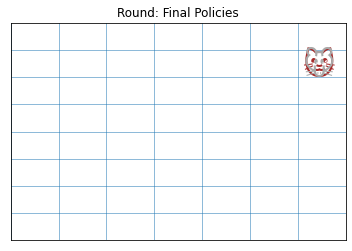

The cat wins in 10 moves.


In [3]:
def init_board():
    # The cat starts in the bottom-left corner; the mouse in the upper-right.
    # The y values start with 0 at the bottom, with the top row being NUM_ROWS-1
    board = {'cat_x': 0, 
             'cat_y': 0, 
             'mouse_x': NUM_COLS-1, 
             'mouse_y': NUM_ROWS-1}
    return board
    

def draw_board(board, round_idx):
    clear_output(wait=True)
    s = sns.scatterplot(x=[], y=[])
    for i in range(NUM_ROWS):
        s.axhline(i, linewidth=0.5)
    for i in range(NUM_COLS):
        s.axvline(i, linewidth=0.5)    
    s.set_xlim(0, NUM_COLS)
    s.set_ylim(0, NUM_ROWS)
    offset = 0.1 
    size = 250 / max(NUM_ROWS, NUM_COLS)
    plt.text(board['cat_x'] + offset, board['cat_y'] + offset, '🐱', size=size, color='brown') 
    plt.text(board['mouse_x'] + offset, board['mouse_y'] + offset, '🐭', size=size, color='darkgray')
    s.set_xticks([])
    s.set_yticks([])
    plt.title(f"Round: {round_idx}")
    plt.show()
    time.sleep(ANIMATION_TIME_PER_MOVE)

    
def set_initial_cat_policy():
    # Initially, the cat is set to simply move towards the mouse
    policy = np.zeros([NUM_COLS, NUM_ROWS, NUM_COLS, NUM_ROWS]).tolist()
    for cat_x in range(NUM_COLS):
        for cat_y in range(NUM_ROWS):
            for mouse_x in range(NUM_COLS):
                for mouse_y in range(NUM_ROWS):
                    
                    if INITIAL_CAT_POLICY == 'WEAK':
                        if cat_y == NUM_ROWS-1:
                            policy[cat_x][cat_y][mouse_x][mouse_y] = 'D'
                        else:
                            policy[cat_x][cat_y][mouse_x][mouse_y] = 'U'                            
                    
                    else: # STRONG
                        dist_x = abs(cat_x - mouse_x)
                        dist_y = abs(cat_y - mouse_y)
                        if dist_x > dist_y:
                            if mouse_x > cat_x:
                                policy[cat_x][cat_y][mouse_x][mouse_y] = 'R'
                            else:
                                policy[cat_x][cat_y][mouse_x][mouse_y] = 'L'
                        else:
                            if mouse_y > cat_y:
                                policy[cat_x][cat_y][mouse_x][mouse_y] = 'U'
                            else:
                                policy[cat_x][cat_y][mouse_x][mouse_y] = 'D'                        
    return policy
                        
        
def set_initial_mouse_policy():  
    # Intially, the mouse is set to simply move up, unless it is in the top row,
    # in which case it moves down. This will initially cause it to oscillate between
    # the top-right corner and the cell immediately below this.
    policy = np.zeros([NUM_COLS, NUM_ROWS, NUM_COLS, NUM_ROWS]).tolist()
    for cat_x in range(NUM_COLS):
        for cat_y in range(NUM_ROWS):
            for mouse_x in range(NUM_COLS):
                for mouse_y in range(NUM_ROWS):
                    if mouse_y == NUM_ROWS-1:
                        policy[cat_x][cat_y][mouse_x][mouse_y] = 'D'
                    else:
                        policy[cat_x][cat_y][mouse_x][mouse_y] = 'U'
    return policy


def convert_board_to_tuple(board):
    return tuple((board['cat_x'], board['cat_y'], board['mouse_x'], board['mouse_y']))


def execute(cat_policy, mouse_policy, draw_execution=False, round_idx=None):
    
    def check_winner(board):
        if convert_board_to_tuple(board) in board_history:
            return 'mouse'
        if (board['cat_x'] == board['mouse_x']) and (board['cat_y'] == board['mouse_y']):
            return 'cat'
        return None
            
    
    def move_cat(board, cat_policy): 
        move = cat_policy[board['cat_x']] \
                         [board['cat_y']] \
                         [board['mouse_x']] \
                         [board['mouse_y']]
        if move == 'R':
            board['cat_x'] += 1
        elif move == 'L':
            board['cat_x'] -= 1
        elif move == 'U':
            board['cat_y'] += 1
        elif move == 'D':
            board['cat_y'] -= 1
        else:
            assert "Invalid move type"                        
        return board
    

    def move_mouse(board, mouse_policy):
        move = mouse_policy[board['cat_x']] \
                           [board['cat_y']] \
                           [board['mouse_x']] \
                           [board['mouse_y']]
        if move == 'R':
            board['mouse_x'] += 1
        elif move == 'L':
            board['mouse_x'] -= 1
        elif move == 'U':
            board['mouse_y'] += 1
        elif move == 'D':
            board['mouse_y'] -= 1
        else:
            assert "Invalid move type"
        return board
    
    def get_distance(board):
        return abs(board['cat_x'] - board['mouse_x']) + abs(board['cat_y'] - board['mouse_y'])
    
    board = init_board()
    board_history = {convert_board_to_tuple(board): True}  
        
    if FIRST_MOVE == 'cat':
        board = move_cat(board, cat_policy)
    
    # Execute for at most the possible number of unique board positions. After this, there must be a cycle if there
    # is no capture.
    for move_number in range(NUM_ROWS * NUM_COLS * NUM_ROWS * NUM_COLS + 1):
        # Move the mouse
        board = move_mouse(board, mouse_policy)
        if draw_execution: 
            draw_board(board, round_idx)
        winner = check_winner(board)
        if winner:
            return winner, move_number, get_distance(board)
        board_history[convert_board_to_tuple(board)] = True
        
        # Move the cat
        board = move_cat(board, cat_policy)
        if draw_execution: 
            draw_board(board, round_idx)
        winner = check_winner(board)
        if winner:
            return winner, move_number, get_distance(board)
        board_history[convert_board_to_tuple(board)] = True
    
    # If the mouse evades capture for the full execution, it is the winner
    assert False, "Executed maximum moves without a capture or repeated board"
    return 'mouse', move_number, get_distance(board)


# todo: this just makes one change per new policy. WRONG!
def get_variations(policy, curr_player):
    num_changes = np.random.randint(1, 11)
    new_policies = []
    for _ in range(num_changes):
        cat_x = np.random.randint(NUM_COLS)
        cat_y = np.random.randint(NUM_ROWS)
        mouse_x = np.random.randint(NUM_COLS)
        mouse_y = np.random.randint(NUM_ROWS)
        direction = np.random.choice(['R', 'L', 'U', 'D'])
        
        # Skip this variation if the move is illegal (going outside the grid)
        if (curr_player == 'cat') and (cat_x == (NUM_COLS-1)) and (direction == 'R'):
            continue
        if (curr_player == 'cat') and (cat_x == 0) and (direction == 'L'):
            continue
        if (curr_player == 'cat') and (cat_y == (NUM_ROWS-1)) and (direction == 'U'):
            continue
        if (curr_player == 'cat') and (cat_y == 0) and (direction == 'D'):
            continue

        if (curr_player == 'mouse') and (mouse_x == (NUM_COLS-1)) and (direction == 'R'):
            continue
        if (curr_player == 'mouse') and (mouse_x == 0) and (direction == 'L'):
            continue
        if (curr_player == 'mouse') and (mouse_y == (NUM_ROWS-1)) and (direction == 'U'):
            continue
        if (curr_player == 'mouse') and (mouse_y == 0) and (direction == 'D'):
            continue            
        
        p = copy.deepcopy(policy)
        p[cat_x][cat_y][mouse_x][mouse_y] = direction
        new_policies.append(p)
    return new_policies


np.random.seed(0)
cat_policy = set_initial_cat_policy()
mouse_policy = set_initial_mouse_policy()
winner, num_moves, distance = execute(cat_policy, mouse_policy, draw_execution=True, round_idx="Initial Policies")
prev_winner, prev_num_moves, prev_distance = winner, num_moves, distance

game_stats_winner = []
game_stats_num_moves = []
game_stats_distance = []
for round_idx in range(100_000):    
    # Display progress as the two players learn
    if (((round_idx % 1000) == 0) and (round_idx > 0)) or \
        (prev_winner != winner) or (prev_num_moves != num_moves) or (prev_distance != distance):
        print(f"Iteration: {round_idx:>6,}, Current winner: {winner:<5}, number of moves until a win: {num_moves:>2}, distance: {distance}")
        prev_winner, prev_num_moves, prev_distance = winner, num_moves, distance
    
    if winner == 'cat':
        # Improve the mouse
        best_p = copy.deepcopy(mouse_policy)
        best_num_moves = num_moves
        best_distance = distance
        policy_variations = get_variations(mouse_policy, curr_player='mouse')        
        for p in policy_variations:
            p_winner, p_num_moves, p_distance = execute(cat_policy, p)
            
            # The mouse's policy improves if it starts winning, the execution takes longer, or the execution takes
            # the same number of time, but the mouse ends farther from the cat
            if ((winner == 'cat') and (p_winner == 'mouse')) or \
               ((winner == 'mouse') and (p_winner == 'mouse') and (p_num_moves > best_num_moves)) or \
               ((winner == 'cat') and (p_winner == 'cat') and (p_num_moves > best_num_moves)) or \
               ((winner == 'cat') and (p_winner == 'cat') and (p_num_moves == best_num_moves) and (p_distance > best_distance)):
                winner = p_winner
                best_p = copy.deepcopy(p)
                best_num_moves = p_num_moves
                best_distance = p_distance
                
        mouse_policy = copy.deepcopy(best_p)
        num_moves = best_num_moves
        distance = best_distance
                
    else:
        # Improve the cat
        best_p = copy.deepcopy(cat_policy)
        best_num_moves = num_moves
        best_distance = distance
        policy_variations = get_variations(cat_policy, curr_player='cat')
        for p in policy_variations:
            p_winner, p_num_moves, p_distance = execute(p, mouse_policy)
            
            # The cat's policy improves if it starts winning, or it wins in fewer moves, or it still loses, but 
            # after more moves, or if it still loses in the same number of moves, but it's closer to the mouse
            if ((winner == 'mouse') and (p_winner == 'cat')) or \
               ((winner == 'mouse') and (p_winner == 'mouse') and (p_distance < best_distance)) or \
               ((winner == 'mouse') and (p_winner == 'mouse') and (p_distance == best_distance) and (p_num_moves > best_num_moves)) or \
               ((winner == 'cat') and (p_winner == 'cat') and (p_num_moves < best_num_moves)):
                winner = p_winner
                best_p = copy.deepcopy(p)
                best_num_moves = p_num_moves
                best_distance = p_distance
                
        cat_policy = copy.deepcopy(best_p)
        num_moves = best_num_moves
        distance = best_distance
        
    game_stats_winner.append(winner)
    game_stats_num_moves.append(num_moves)
    game_stats_distance.append(distance)
     
    draw_execution = (round_idx % 10_000 == 0) and (round_idx > 0)
    if draw_execution:
        execute(cat_policy, mouse_policy, draw_execution=True, round_idx=round_idx)
            
winner, num_moves, distance = execute(cat_policy, mouse_policy, draw_execution=True, round_idx="Final Policies")            
print(f"The {winner} wins in {num_moves} moves.")

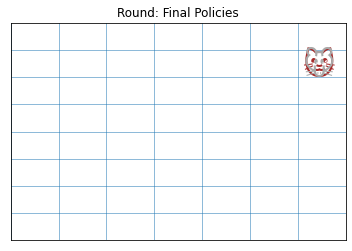

The cat wins in 10 moves.


In [8]:
winner, num_moves, distance = execute(cat_policy, mouse_policy, draw_execution=True, round_idx="Final Policies")            
print(f"The {winner} wins in {num_moves} moves.")

In [4]:
pd.Series(game_stats_winner).value_counts()

mouse    54760
cat      45240
dtype: int64